# Simulation of chirp compression

July 3, 2018

Reference: 
- [Sound Synthesis with Numpy](https://dzone.com/articles/sound-synthesis-numpy)
- [Radar Pulse Compression](https://www.ittc.ku.edu/workshops/Summer2004Lectures/Radar_Pulse_Compression.pdf)

In [168]:
%matplotlib inline
%run ./signal.py

In [169]:
s = Signal(f0=440, f1=1760, fs=44100, T=0.0205, A=20000)
sl = Signal(f0=440, f1=1760, fs=44100, T=2.0, A=20000)

## Up chirp

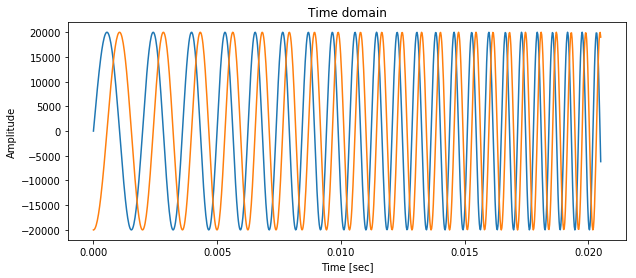

In [170]:
# Upchirp by complex exponential function
s.plot_wave(s.chirp())

In [172]:
sl.play(sl.chirp())

Frequencies at peaks: [ 462. 1738.] Hz


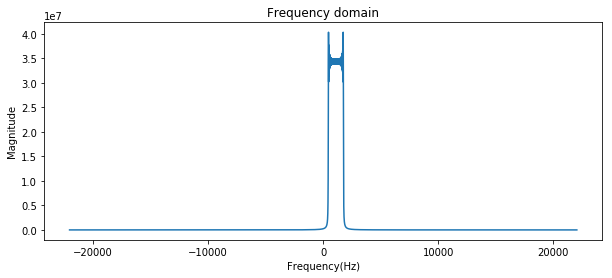

In [173]:
sl.plot_fft(sl.chirp())

Frequencies at peaks: [-1738.  -462.   462.  1738.] Hz


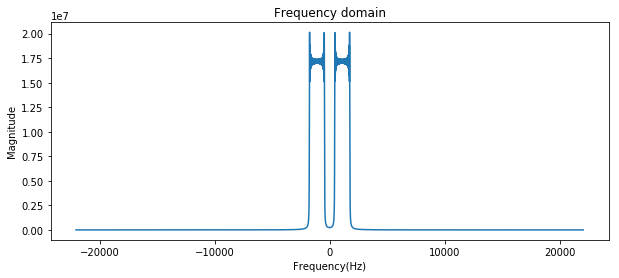

In [174]:
sl.plot_fft(sl.chirp_cos())

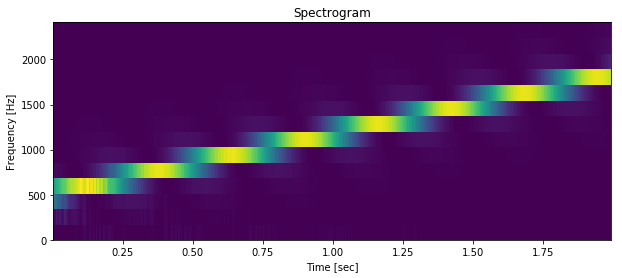

In [175]:
sl.plot_spectrogram(sl.chirp(), band=15)

## Up chirp * up chirp

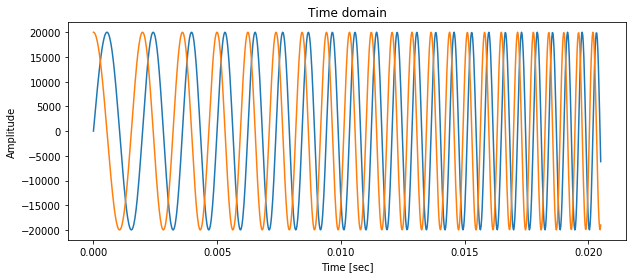

In [176]:
# Up chirp conjugate
s.plot_wave(s.chirp().conjugate(), real_only=False)

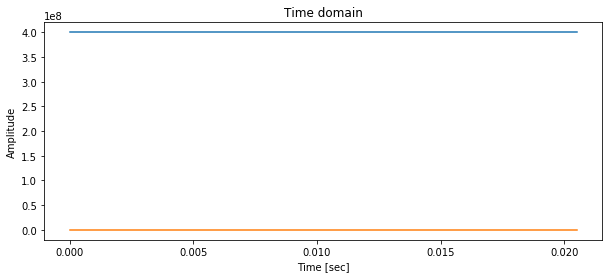

In [177]:
# Up chirp * up chirp conjugate becomes DC
s.plot_wave(s.chirp() * s.chirp().conjugate())

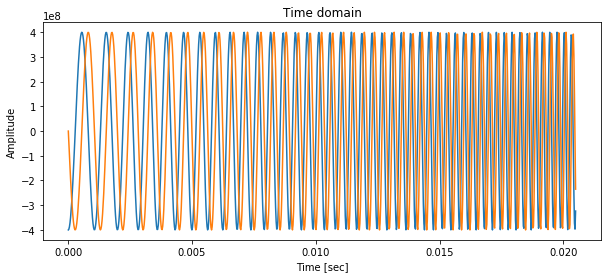

In [178]:
# Up chirp * up chirp becomes chirp with doubled frequency and DC offset
s.plot_wave(s.chirp() * s.chirp())

Frequencies at peaks: [0.] Hz


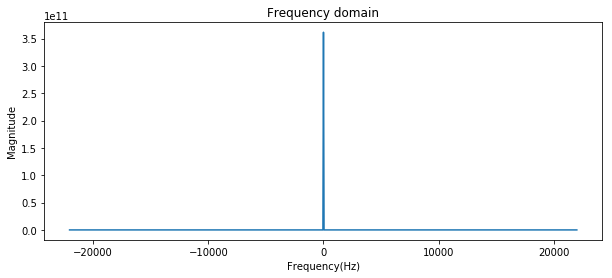

In [179]:
s.plot_fft(s.chirp() * s.chirp().conjugate())

Frequencies at peaks: [0.] Hz


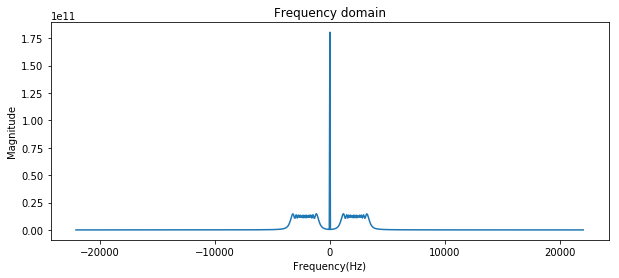

In [180]:
# Chirp squared term
s.plot_fft(s.chirp_cos() * s.chirp_cos())

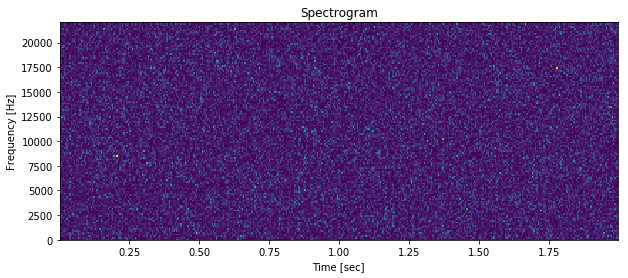

In [181]:
sl.plot_spectrogram(sl.chirp() * sl.chirp().conjugate(), band=150)

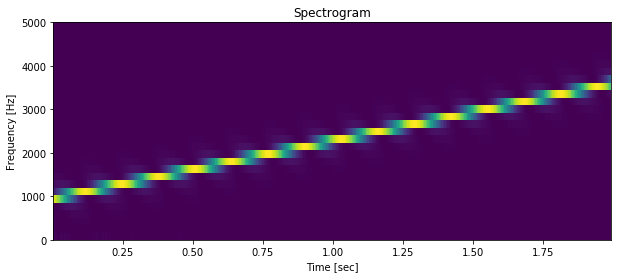

In [182]:
# Chirp squared term
sl.plot_spectrogram(sl.chirp_cos() * sl.chirp_cos(), band=30)

## Up chirp * Down chirp

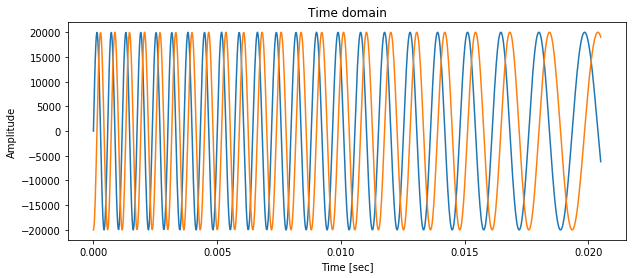

In [183]:
s.plot_wave(s.chirp(updown="down"))

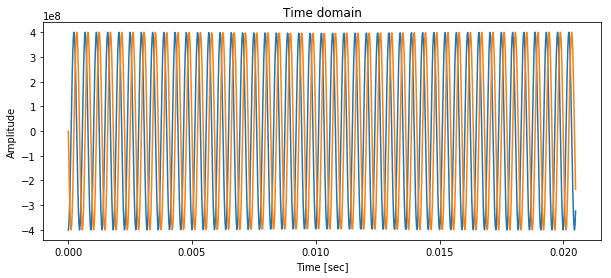

In [184]:
s.plot_wave(s.chirp() * s.chirp(updown="down"))

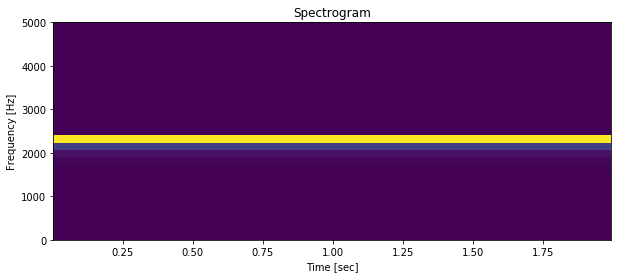

In [185]:
sl = Signal(f0=440, f1=1760, fs=44100, T=2.0, A=sqrt(20000))
sl.plot_spectrogram(sl.chirp() * sl.chirp(updown="down"), band=30)
sl.play(sl.chirp() * sl.chirp(updown="down"))

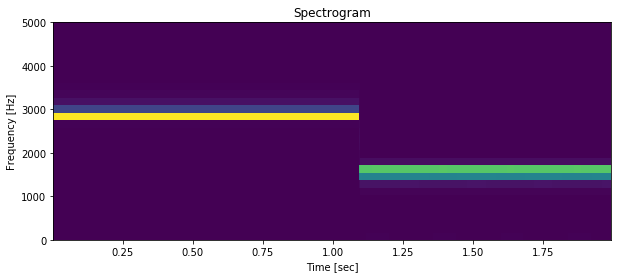

In [186]:
# Unsynchronized upchirp * downchirp
upchirp=sl.chirp()
sl.plot_spectrogram(append(upchirp[40000:], upchirp[:40000]) * sl.chirp(updown="down"), band=30)
sl.play(append(upchirp[40000:], upchirp[:40000]) * sl.chirp(updown="down"))

Frequencies at peaks: [2200.] Hz


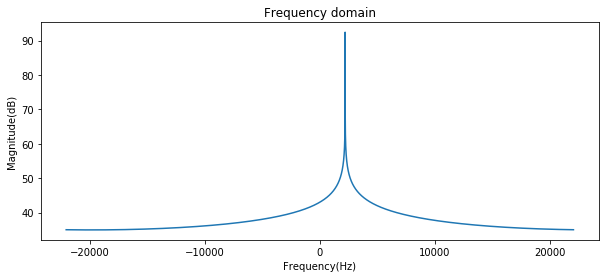

In [187]:
sl.plot_fft(sl.chirp() * sl.chirp(updown="down"), logscale=True)

## Radar system

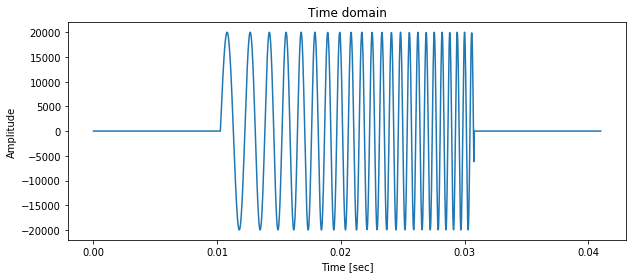

In [188]:
# Upchirp by cosine function (delay = chirp length in time * 0.5)
s.plot_wave(add_delay(s.chirp_cos(), 0.5), real_only=True)

Frequencies at peaks: [0.] Hz


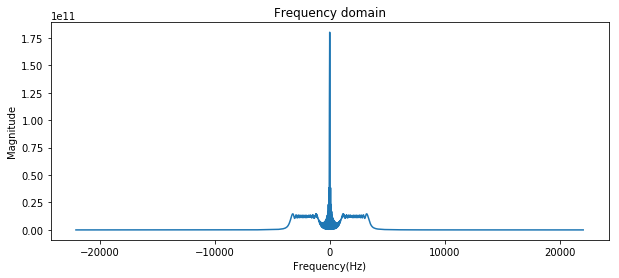

In [190]:
sr = Signal(f0=440, f1=440+(1760-440)*2, fs=44100, T=0.0205*2, A=20000)
srl = Signal(f0=440, f1=440+(1760-440)*2, fs=44100, T=4.0, A=20000)
s.plot_fft(add_delay(s.chirp_cos(), 0.0) * sr.chirp_cos())

Frequencies at peaks: [-658.57300885  658.57300885] Hz


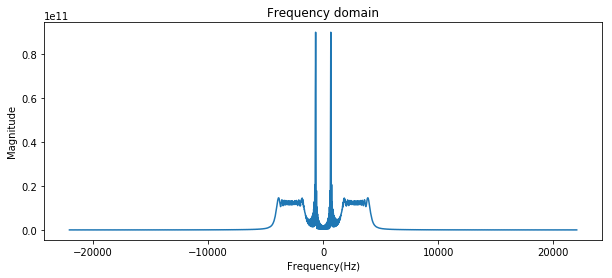

In [191]:
s.plot_fft(add_delay(s.chirp_cos(), 0.5) * sr.chirp_cos())

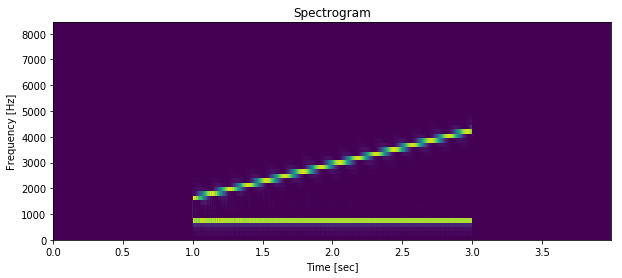

In [192]:
srl.plot_spectrogram(add_delay(sl.chirp_cos(), 0.5) * srl.chirp_cos(), band=50)

Frequencies at peaks: [-660. -396. -132.  132.  396.  660.] Hz


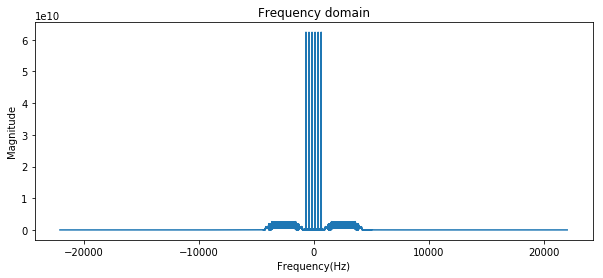

In [193]:
echo0 = add_delay(sl.chirp_cos(), 0.1)
echo1 = add_delay(sl.chirp_cos(), 0.3)
echo2 = add_delay(sl.chirp_cos(), 0.5)
echos = echo0 + echo1 + echo2
srl.plot_fft(echos * srl.chirp_cos())

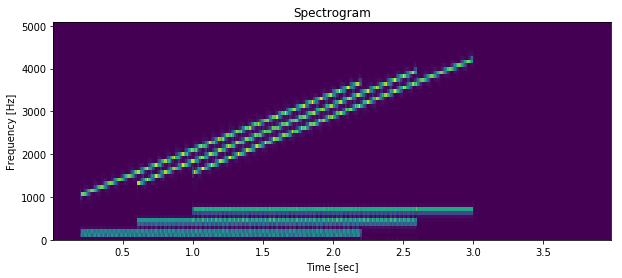

In [194]:
r = echos * srl.chirp_cos()
srl.plot_spectrogram(r, nperseg=512, band=60)

## Compress chirp in frequency domain (chirp signal under noise level)

### Complex chirp signal

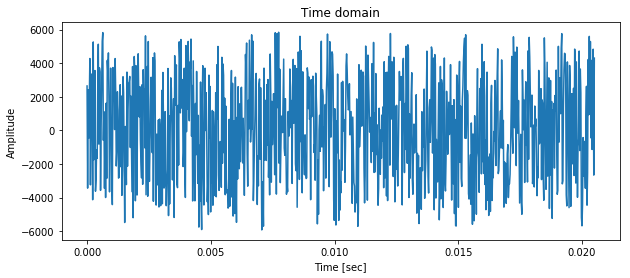

In [195]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 5000)
s = Signal(f0=440, f1=1760, fs=44100, T=0.0205, A=1000)
s.plot_wave(s.chirp() + s.white_noise(A=5000), real_only=True)

Frequencies at peaks: [-10927.43362832  -1658.62831858] Hz


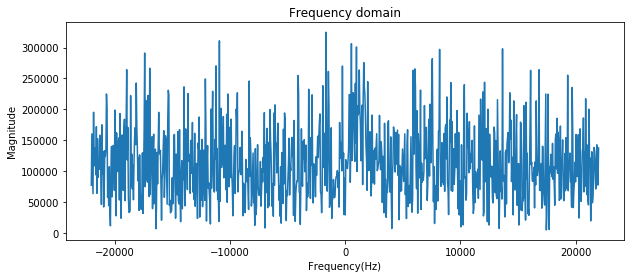

In [196]:
s.plot_fft(s.chirp() + s.white_noise(A=5000))

Frequencies at peaks: [0.] Hz


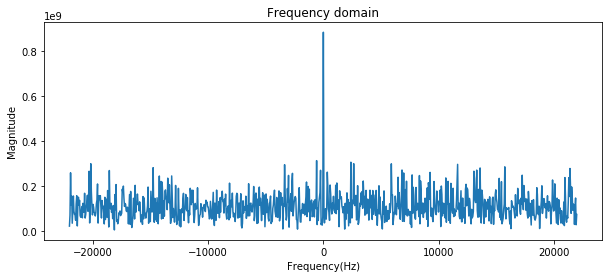

In [197]:
s.plot_fft((s.chirp() + s.white_noise(A=5000)) * s.chirp().conjugate())

# Compress chirp in time domain

Due to the small number of samples, the chirp signal is not so compressed in time domain.

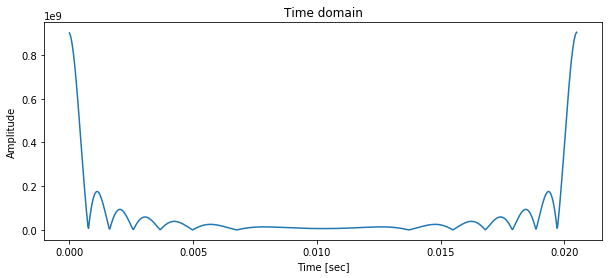

In [201]:
# Here, I use IFFT and FFT rather than filter functions
s.plot_wave(abs(ifft(fft(s.chirp()) * fft(s.chirp(updown="down")))), real_only=True)

With the large number of samples, the signal is so compressed in time domain.

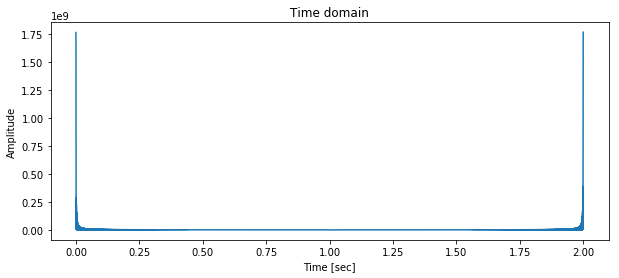

In [203]:
sl.plot_wave(abs(ifft(fft(sl.chirp()) * fft(sl.chirp(updown="down")))), real_only=True)